# Reprojection

In this notebook, we learn how to reproject raster images into a new CRS. 4 different methods will be presented and distinguished by 2 factors: the input data (either files from disk/cloud vs. in-memory data), and the toolchain (GDAL-dependent vs. no GDAL). They are:

- Option 1: Reproject *while loading* with [stackstac](https://stackstac.readthedocs.io/en/latest/) (*in-loading, GDAL-dependent*)
- Option 2: Reproject *while loading* with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) using a WarpedVRT (*in-loading, GDAL-dependent*)
- Option 3: Reproject an *in-memory* DataArray with [rioxarray](https://corteva.github.io/rioxarray/stable/) / [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) (*in-memory, GDAL-dependent*)
- Option 4: Reproject an *in-memory* array with [stackstac](https://stackstac.readthedocs.io/en/latest/) (*in-memory, no GDAL*)

*In-loading* data reprojection has a lower memory footprint, and works on large datasets. In constrast, reprojecting *in-memory* data only works with datasets that fit the memory of the machine it's running on. Thus, unlikely to work with a large distributed dataset. If you can do reprojection both ways, it depends on *how big your data is* in order to choose between *in-loading* (options 1 and 2) and *in-memory* (options 3 and 4). In case you can't reproject the data while reading, for example, the data array is the result of some calculations or preprocessing steps, then it's just *toolchain preference*, whether you're used to *GDAL* (option 3) or not (option 4).

Data using in this example is from *Sentinel-2* satellite imagery. To create true color images for visualization, we use `true_color` function from [xrspatial.multispectral](https://xarray-spatial.org/index.html)

Let's get started by importing all necessary libraries.

In [1]:
import planetary_computer as pc
import pystac_client

import numpy as np
import xarray as xr

import stackstac
import affine
import pyproj
import rioxarray
import rasterio

from rioxarray.rioxarray import _make_coords
from rasterio.vrt import WarpedVRT

import xrspatial.multispectral as ms
import matplotlib.pyplot as plt

## Local Dask Cluster

We use a small dataset so let's create a local Dask Cluster.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


## Study data

The region of interest in this section is located in Colorado, USA, centered by Cochetopa Dome and Sawtooth Mountain. We first choose a single scene by its ID as below.

In [3]:
item_id = ["S2B_MSIL2A_20190924T175049_N0212_R141_T13SCC_20201004T164728.SAFE"]

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
search = catalog.search(collections=["sentinel-2-l2a"], ids=item_id)

item = [pc.sign_assets(i).to_dict() for i in search.items()][0]

item["properties"]["proj:epsg"]

32613

## Reproject while loading with [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html)
The selected scene is stored in `EPSG:32613` coordinate system. Let's reproject it to a new CRS by providing the destination `epsg` number to the function [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html), which uses [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) internally. In this example, we consider the Lambert Cylindrical projection.

#### Lambert Cylindrical Projection (EPSG: 6933)
Lambert Cylindrical is an equal area projection, a map projection that preserves area measure. Regions with the same size on the Earth have the same size on the map but generally distort the shape, angle, and scale.

In [4]:
scene_data = (
    stackstac.stack(
        item,
        epsg=6933,
        assets=["B04", "B03", "B02"],  # red, green, blue bands
        resolution=100,
        chunksize=2048,
    )
    .isel(time=0)
    .persist()
)

scene_data

<xarray.DataArray 'stackstac-0f2acc6c8135fa7bebd7d4a9d1e460ad' (band: 3, y: 995, x: 1235)>
dask.array<getitem, shape=(3, 995, 1235), dtype=float64, chunksize=(1, 995, 1235), chunktype=numpy.ndarray>
Coordinates: (12/46)
    time                                     datetime64[ns] 2019-09-24T17:50:...
    id                                       <U65 'S2B_MSIL2A_20190924T175049...
  * band                                     (band) <U3 'B04' 'B03' 'B02'
  * x                                        (x) float64 -1.035e+07 ... -1.02...
  * y                                        (y) float64 4.591e+06 ... 4.491e+06
    sat:relative_orbit                       int64 141
    ...                                       ...
    gsd                                      int64 10
    title                                    (band) <U20 'Band 4 - Red - 10m'...
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 6933
Attributes:
    spec:        RasterSpec(epsg=6933, bounds=(-10353400, 4491300, -10229900,...
    crs:         epsg:6933
    transform:   | 100.00, 0.00,-10353400.00|\n| 0.00,-100.00, 4590800.00|\n|...
    resolution:  100

With [xrspatil.multispectral.true_color](https://xarray-spatial.org/reference/multispectral.html) function, we can create a true color image to see how the data looks like.

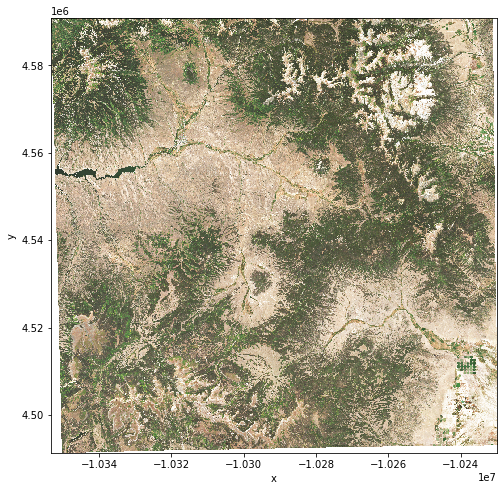

In [5]:
# visualize selected scene
cylindrical_img = ms.true_color(*scene_data, name="epsg=6933")
cylindrical_img.plot.imshow(figsize=(8, 8));

## Reproject while loading with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) using a `WarpedVRT`

`WarpedVRT` does not require prior download of GeoTIFF files, we provide the URLs directly as the inputs. In following script, we fetch data from the Microsoft Sentinel-2 Azure Blob Storage and reproject them from their source CRS of `EPSG:32613` to the Robinson CRS of `ESRI:54030`.

In [6]:
urls = {
    "red": item["assets"]["B04"]["href"],
    "green": item["assets"]["B03"]["href"],
    "blue": item["assets"]["B02"]["href"],
}

#### Robinson (ESRI:54030)

The Robinson projection is a map projection of a world map that does not preserve equal-area nor conformal. Both the lines of altitude and longitude are evenly spaced across the map for a compromise.

In this example, we use `ESRI:54030` as the target/destination CRS and demonstrate how to normalize a stack of images against a regular grid in a defined bounding box with following steps:
- Get rasterio CRS for `ESRI:54030` (Note that in case you want to reproject to an `EPSG` CRS, e.g: EPSG:4326, simply put its number, 4326, as the destination CRS.)
- Define a shape (height, width), and bounding box (coords) for the target reprojected/destination image.
- Calculate transform to reproject from source CRS to destination CRS.
- Provide all above information to `WarpedVRT`, including: destination CRS, destination shape, and destination transform.
- Finally, do the projection.

In [7]:
robinson_crs = pyproj.crs.CRS.from_string("ESRI:54030")
robinson_crs = rasterio.crs.CRS.from_wkt(robinson_crs.to_wkt())
robinson_crs

CRS.from_wkt('PROJCS["World_Robinson",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54030"]]')

In [8]:
height = width = 1000
robinson_bounds = (-9438051, 4153437, -9285636, 4046189)

# calculate destination transform
left, bottom, right, top = robinson_bounds
xres = (right - left) / width
yres = (top - bottom) / height
robinson_transform = affine.Affine(xres, 0.0, left, 0.0, -yres, top)

robinson_transform

Affine(152.415, 0.0, -9438051.0,
       0.0, 107.248, 4046189.0)

In [9]:
robinson_vrt_options = {
    "crs": robinson_crs,
    "transform": robinson_transform,
    "height": height,
    "width": width,
}

In [10]:
robinson_reproj = []

for _, url in urls.items():
    with rasterio.open(url) as src:
        with WarpedVRT(src, **robinson_vrt_options) as vrt:
            reproj = rioxarray.open_rasterio(vrt).chunk(
                {"x": 1000, "y": 1000, "band": 1}
            )
            robinson_reproj.append(reproj)

robinson_reproj = xr.concat(robinson_reproj, dim="band")

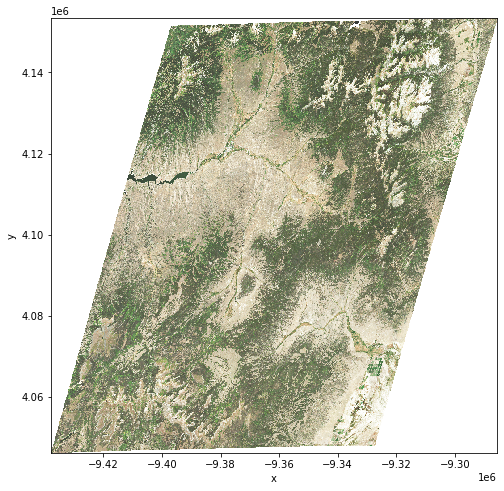

In [11]:
# visualize
robinson_img = ms.true_color(
    *robinson_reproj, name="esri=54030", contrast=20, th=0.0625
)
robinson_img.plot.imshow(figsize=(8, 8));

## Reproject an in-memory DataArray with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html)

[rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) provide tools for raster warping and reprojection that uses GDAL under the hood.

#### Web Mercator (EPSG:3857)

Web Mercator, the standard for Web mapping applications, is a variant of the Mercator projection. Its usage spans widely over major online map providers. In the below, we reproject our scene data from the CRS of `EPSG:6933` to Web Mercator CRS of `EPSG:3857` with [rioxarray](https://corteva.github.io/rioxarray/stable/)

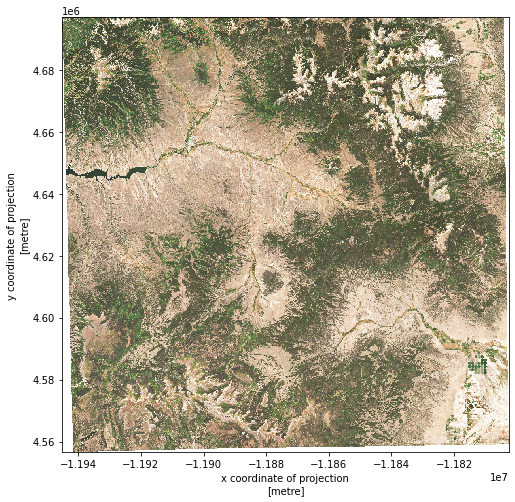

In [12]:
web_mecator_crs = 3857

web_mecator_reproj = scene_data.rio.reproject(web_mecator_crs)
web_mecator_img = ms.true_color(*web_mecator_reproj, name="epsg=3857")

web_mecator_img.plot.imshow(figsize=(8, 8));

#### WGS84 projection - lat/lon (equirectangular) projection (EPSG:4326)
This very common one displays meridians and parallels as equally spaced vertical and horizontal lines. Conversion between x, y coordinates on the map and earth locations are very simple, and this is a very popular one for general use. However, the significant distortions inherent to this method make it impractical for many scientific application. Let's see how our data looks in this crs by reprojecting it with [rasterio.warp.reproject](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.reproject) with following steps:

- Get shape, CRS, bounds and transform information from the source dataset.
- Define destination CRS.
- Calculate the shape, transform and coords of the destination.
- Reproject the source data to destination CRS and reconstruct the result.

In [13]:
# source information
src_crs = {"init": scene_data.crs}
src_bounds = scene_data.rio.bounds()
src_transform = scene_data.transform
bands, src_height, src_width = scene_data.shape

In [14]:
# destination CRS
WGS84_crs = {"init": "EPSG:4326"}

# calculate destination transform
WGS84_transform, WGS84_width, WGS84_height = rasterio.warp.calculate_default_transform(
    src_crs, WGS84_crs, src_width, src_height, *src_bounds
)
# array to write results to
WGS84_data = np.zeros((bands, WGS84_height, WGS84_width))

WGS84_transform, WGS84_width, WGS84_height

(Affine(0.0010199914261785408, 0.0, -107.30489322500127,
        0.0, -0.0010199914261785408, 38.827024319904964),
 1255,
 970)

In [15]:
# coords of the destination
WGS84_coords = _make_coords(
    scene_data, WGS84_transform, WGS84_width, WGS84_height, WGS84_crs
)

WGS84_xs = WGS84_coords["x"]
WGS84_ys = WGS84_coords["y"]

In [16]:
rasterio.warp.reproject(
    scene_data,
    WGS84_data,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=WGS84_transform,
    dst_crs=WGS84_crs,
)

# reconstruct result as an xarray DataArray
WGS84_reproj = xr.DataArray(
    WGS84_data,
    dims=["band", "y", "x"],
    coords={"band": scene_data.band, "y": WGS84_ys, "x": WGS84_xs},
)

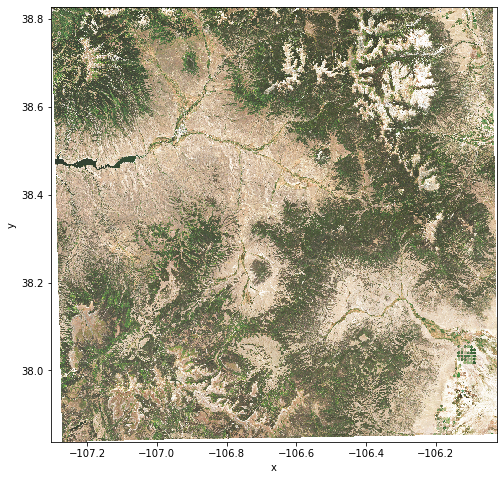

In [17]:
WGS84_img = ms.true_color(*WGS84_reproj, name="epsg=4326")
WGS84_img.plot.imshow(figsize=(8, 8));

## Reproject an in-memory array with [stackstac.reproject_array](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.reproject_array.html)

`stackstac` provides a tool called `reproject_array` that uses [scipy.interpolate.interpn](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html) internally to reproject and clip a `xarray.DataArray` to a new destination CRS. No GDAL dependency required. `reproject_array` takes a DataArray as input data, we'll use the scene data created from the beginning to do experiments in this section.

#### Space Oblique (EPSG: 29873)

Space Oblique is a projection especially designed for satellite imagery so that it is completely free of distortion along the orbit path of the satellite.

In [18]:
space_oblique_crs = 29873
space_oblique_bounds = stackstac.array_bounds(scene_data, space_oblique_crs)

space_oblique_spec = stackstac.raster_spec.RasterSpec(
    epsg=space_oblique_crs, bounds=space_oblique_bounds, resolutions_xy=(100, 100)
)

space_oblique_spec

RasterSpec(epsg=29873, bounds=(10675077.084681889, 9757187.124107027, 10823668.536491105, 9906913.424226366), resolutions_xy=(100, 100))

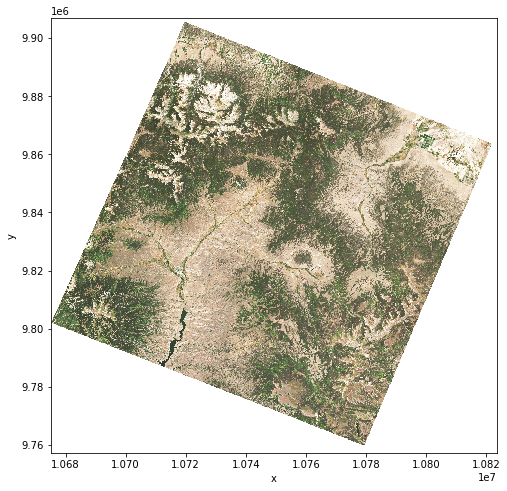

In [19]:
space_oblique_reproj = stackstac.reproject_array(scene_data, space_oblique_spec)

space_oblique_img = ms.true_color(*space_oblique_reproj, name="epsg=29873")
space_oblique_img.plot.imshow(figsize=(8, 8));

### Show results

Let's plot all images and put them side by side to have an overview of what we have done so far.

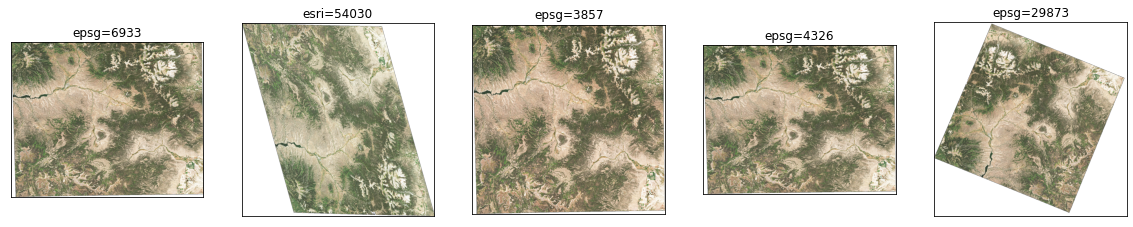

In [20]:
imgs = [cylindrical_img, robinson_img, web_mecator_img, WGS84_img, space_oblique_img]

fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(20, 15))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i].data)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(imgs[i].name)

plt.show()